In [2]:
import numpy as np
import scipy as sp
import pystan
import arviz
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

# Model Checking - Algotrading

In this notebook we perform model checking on the algotrading problem from Q2. The original model is our solution to Q2, which is:

$$ tau \sim InverseGamma(3,1) $$
$$ eta \sim Normal(0, 1) $$
$$ theta = mu + tau * eta$$
$$ y \sim Normal(theta, \sigma)$$
 
 
The modified model we propose is by adding another level of hierarchy to the model:

$$ \alpha \sim Cauchy(0, 5) $$
$$ \beta \sim Cauchy(0, 5) $$
$$ tau \sim Gamma(\alpha, \beta)$$

 


## Model (hw2) - Inverse Gamma prior

Define the model in the code cell below.

The model is normal hierarchy model, since we assume the changes in the three days are from normal distibution

In [3]:
model = """
data {
    int<lower=0> J;
    vector[J] y;
    vector<lower=0>[J] std;
}
parameters {
    real mu;
    real<lower=0> tau;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    tau ~ inv_gamma(3,1);
    eta ~ normal(0, 1);
    y ~ normal(theta, std);
}
"""

## Data

Load or hardcode the data in the code cell below.

In [4]:
data = {'Sunday':
    [1.0883, 1.1071, 1.0943, 1.1089, 1.1629, 1.0994, 1.1022, 1.1364, 1.0903,
     1.1153, 1.097, 1.0978, 1.1393, 1.1653, 1.1104, 1.1099, 1.119, 1.0983,
     1.1145, 1.1225, 1.1196, 1.1165, 1.0868, 1.1154, 1.1494, 1.1467, 1.1457,
     1.0982, 1.098, 1.1299, 1.1162, 1.079, 1.1523],

'Monday':
    [1.0426, 1.0589, 1.0564, 1.0509, 1.0745, 1.0509, 1.0609, 1.0691, 1.0632,
     1.0627, 1.0699, 1.0496, 1.0582, 1.0643, 1.0741, 1.0551, 1.0681, 1.0538,
     1.0657, 1.0581, 1.0471, 1.066, 1.0631, 1.0764, 1.0787, 1.059, 1.0383,
     1.0685, 1.0773, 1.0644, 1.068, 1.062, 1.077, 1.0622, 1.0764],

'Tuesday':
    [1.0779, 1.0873, 1.092, 1.0805, 1.0971, 1.0823, 1.0857, 1.0797,
     1.0872, 1.0874, 1.1113, 1.1012, 1.0961, 1.0983, 1.0952, 1.0862,
     1.1066, 1.077, 1.093, 1.0867, 1.0851, 1.0907, 1.1207, 1.1011,
     1.0717, 1.0948, 1.1004, 1.0908, 1.0825, 1.0797, 1.0776, 1.0876,
     1.0795, 1.1051, 1.093, 1.1152, 1.0992, 1.0975, 1.1008, 1.1158,
     1.0933, 1.0948, 1.1047, 1.1025, 1.0936, 1.1072, 1.0844, 1.0954, 1.1066]}


In [5]:
# Now computing mean and std for each day
mean = []
std = []
for key, val in data.items():
    mean.append(np.mean(val))
    std.append(np.std(val))
    
print(mean, std)

[1.1161454545454546, 1.0626114285714283, 1.093469387755102] [0.022386387786481356, 0.00995761794316497, 0.011004270118896833]


In [6]:
sm = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_230fcfea9b71f20404cb0322c605b093 NOW.


In [7]:
op = sm.optimizing(data=dict(y=mean, std=std, J=len(mean)))
op

OrderedDict([('mu', array(1.09068143)),
             ('tau', array(0.25142059)),
             ('eta', array([ 0.10048415, -0.11147128,  0.01106744])),
             ('theta', array([1.11594521, 1.06265526, 1.09346401]))])

In [8]:
fit = sm.sampling(data=dict(y=mean, std=std, J=len(mean)), chains=4, iter=10000)
print(fit)

Inference for Stan model: anon_model_230fcfea9b71f20404cb0322c605b093.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         1.08  3.2e-3   0.15   0.78    1.0   1.08   1.17    1.4   2151    1.0
tau        0.25  6.7e-3   0.14    0.1   0.16   0.22    0.3   0.59    410   1.01
eta[1]     0.15  9.9e-3   0.58  -0.98  -0.25   0.15   0.55   1.29   3496    1.0
eta[2]    -0.11  9.8e-3   0.58  -1.24  -0.52  -0.11   0.28   1.01   3529    1.0
eta[3]     0.04  9.8e-3   0.58  -1.08  -0.36   0.04   0.43   1.16   3503    1.0
theta[1]   1.12  1.7e-4   0.02   1.07    1.1   1.12   1.13   1.16  16287    1.0
theta[2]   1.06  6.9e-5   0.01   1.04   1.06   1.06   1.07   1.08  21148    1.0
theta[3]   1.09  7.9e-5   0.01   1.07   1.09   1.09    1.1   1.12  19656    1.0
lp__      -2.49    0.02   1.71  -6.73   -3.4  -2.14  -1.23  -0.18   4895    1.0

Samples 

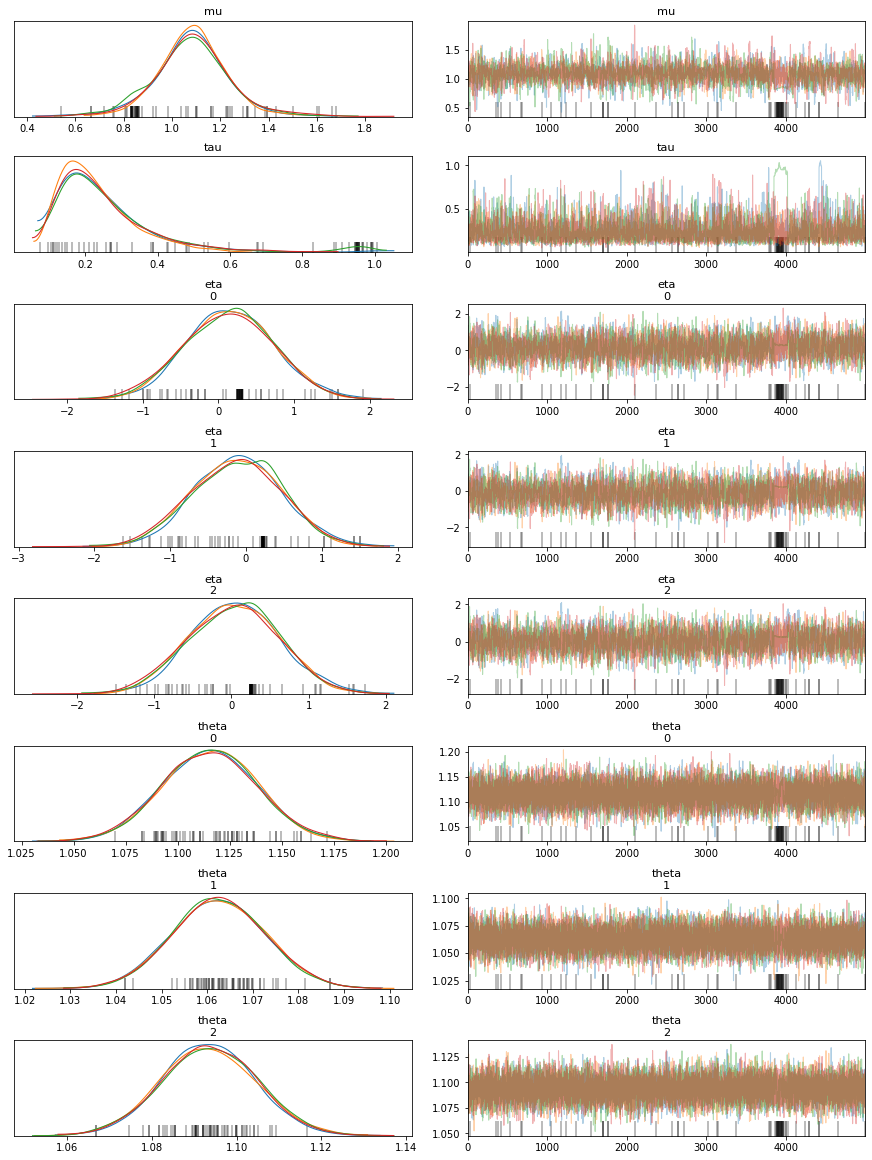

In [9]:
_ = arviz.plot_trace(fit)

####  Extracting the samples

In [10]:
extracted = fit.extract()
mu = np.array(extracted['mu'])
tau = np.array(extracted['tau'])
eta = np.array(extracted['eta'])
theta = np.array(extracted['theta'])
logp = np.array(extracted['lp__'])

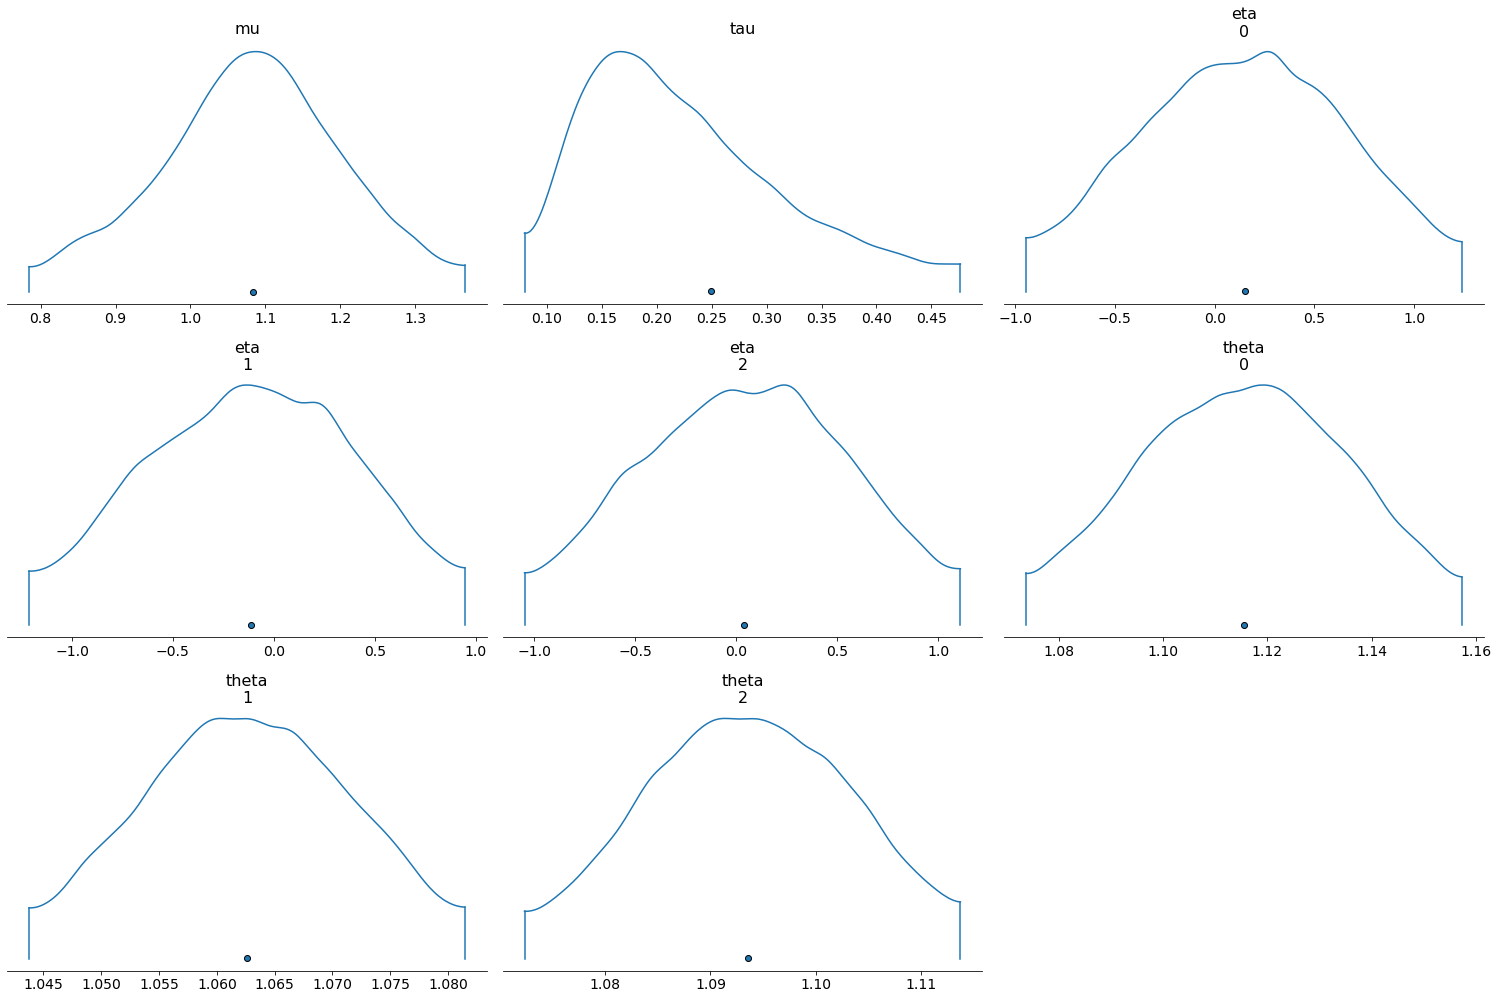

In [11]:
_ = arviz.plot_density(arviz.convert_to_inference_data(fit))

# Model 2 - Extended Hierarchy 

In [12]:
model2 = """
data {
    int<lower=0> J;
    vector[J] y;
    vector<lower=0>[J] std;
}
parameters {
    real mu;
    real<lower=0> tau;
    real<lower=0> alpha;
    real<lower=0> beta;
    vector[J] eta;
}
transformed parameters {
    vector[J] theta;
    theta = mu + tau * eta;
}
model {
    alpha ~ cauchy(0, 5);
    beta ~ cauchy(0, 5);
    tau ~ gamma(alpha,beta);
    eta ~ normal(0, 1);
    y ~ normal(theta, std);
}
"""

In [13]:
sm2 = pystan.StanModel(model_code=model2)
fit2 = sm2.sampling(data=dict(y=mean, std=std, J=len(mean)), iter=10000, chains=4)
print(fit2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_be9889b11f66407205ce68a0dab13f4e NOW.


Inference for Stan model: anon_model_be9889b11f66407205ce68a0dab13f4e.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu         1.09  2.9e-3   0.02   1.04   1.08   1.09    1.1   1.15     73   1.07
tau        0.04  4.6e-3   0.04 4.5e-6   0.01   0.03   0.05   0.16     93   1.05
alpha      2.24    0.08   3.42   0.08   0.58   1.29   2.55  10.92   2013    1.0
beta      106.8   11.77 1148.6   1.04   6.88  17.53  58.04 542.63   9524    1.0
eta[1]     0.44    0.02   0.79  -1.12  -0.07   0.42   0.94   2.05   1772   1.01
eta[2]    -0.65    0.01   0.77  -2.21  -1.12  -0.64  -0.17   0.87   3208    1.0
eta[3]     0.18    0.02   0.74   -1.2  -0.32   0.15   0.63   1.74   1181   1.01
theta[1]    1.1  9.7e-4   0.02   1.07   1.08    1.1   1.12   1.15    486   1.01
theta[2]   1.07  1.6e-4   0.01   1.05   1.06   1.07   1.08   1.09   4683    1.0
theta[3] 

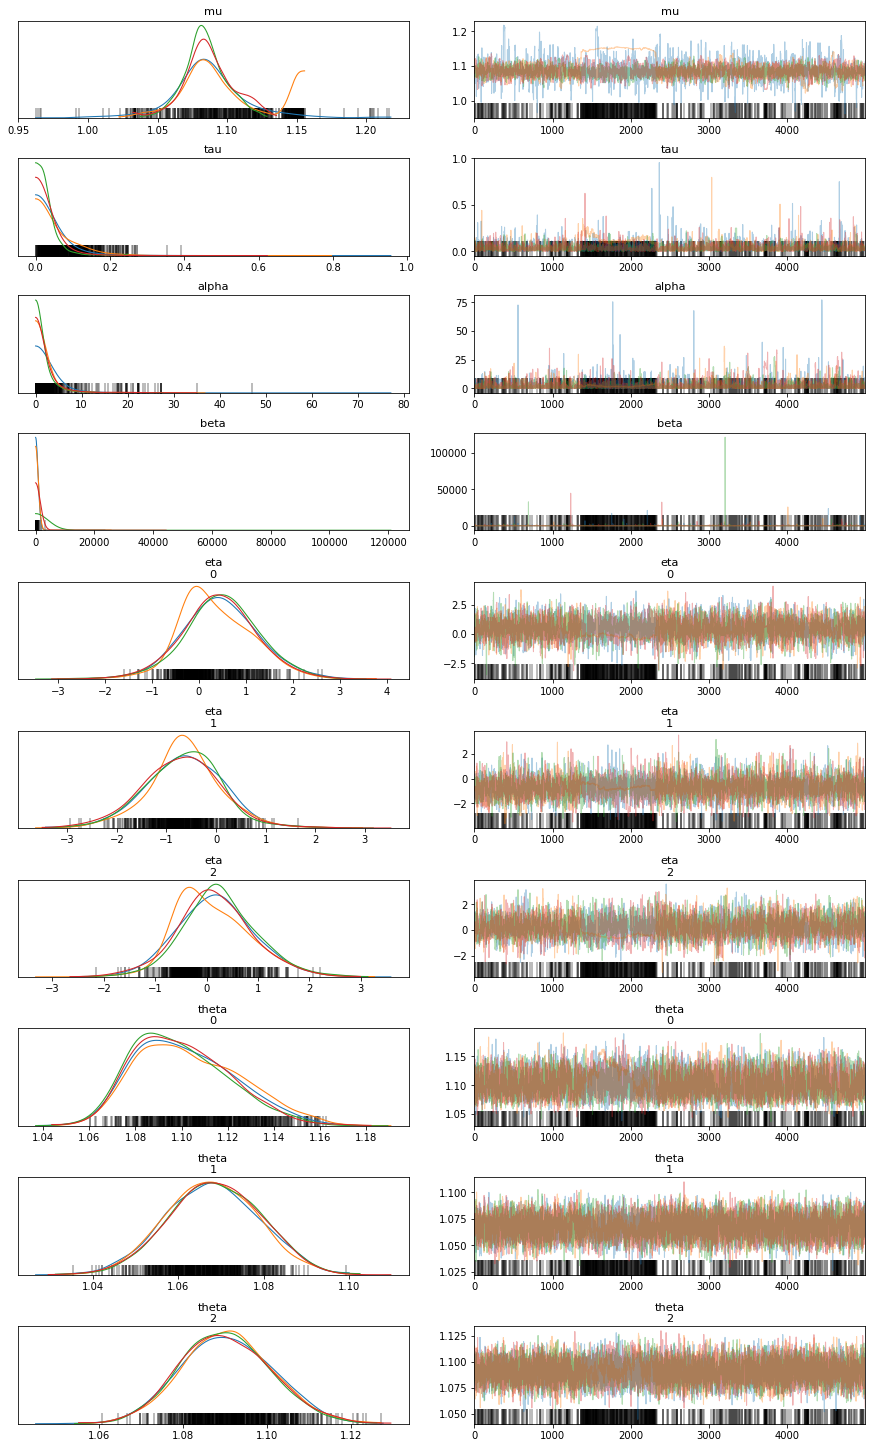

In [14]:
_ = arviz.plot_trace(fit2)

In [15]:
fit2.extract(permuted = True)
mu2 = np.array(fit2.extract()['mu'])
tau2 = np.array(fit2.extract()['tau'])
eta2 = np.array(fit2.extract()['eta'])
theta2 = np.array(fit2.extract()['theta'])
logp2 = np.array(fit2.extract()['lp__'])
alpha2 = np.array(fit2.extract()['alpha'])
beta2 = np.array(fit2.extract()['beta'])

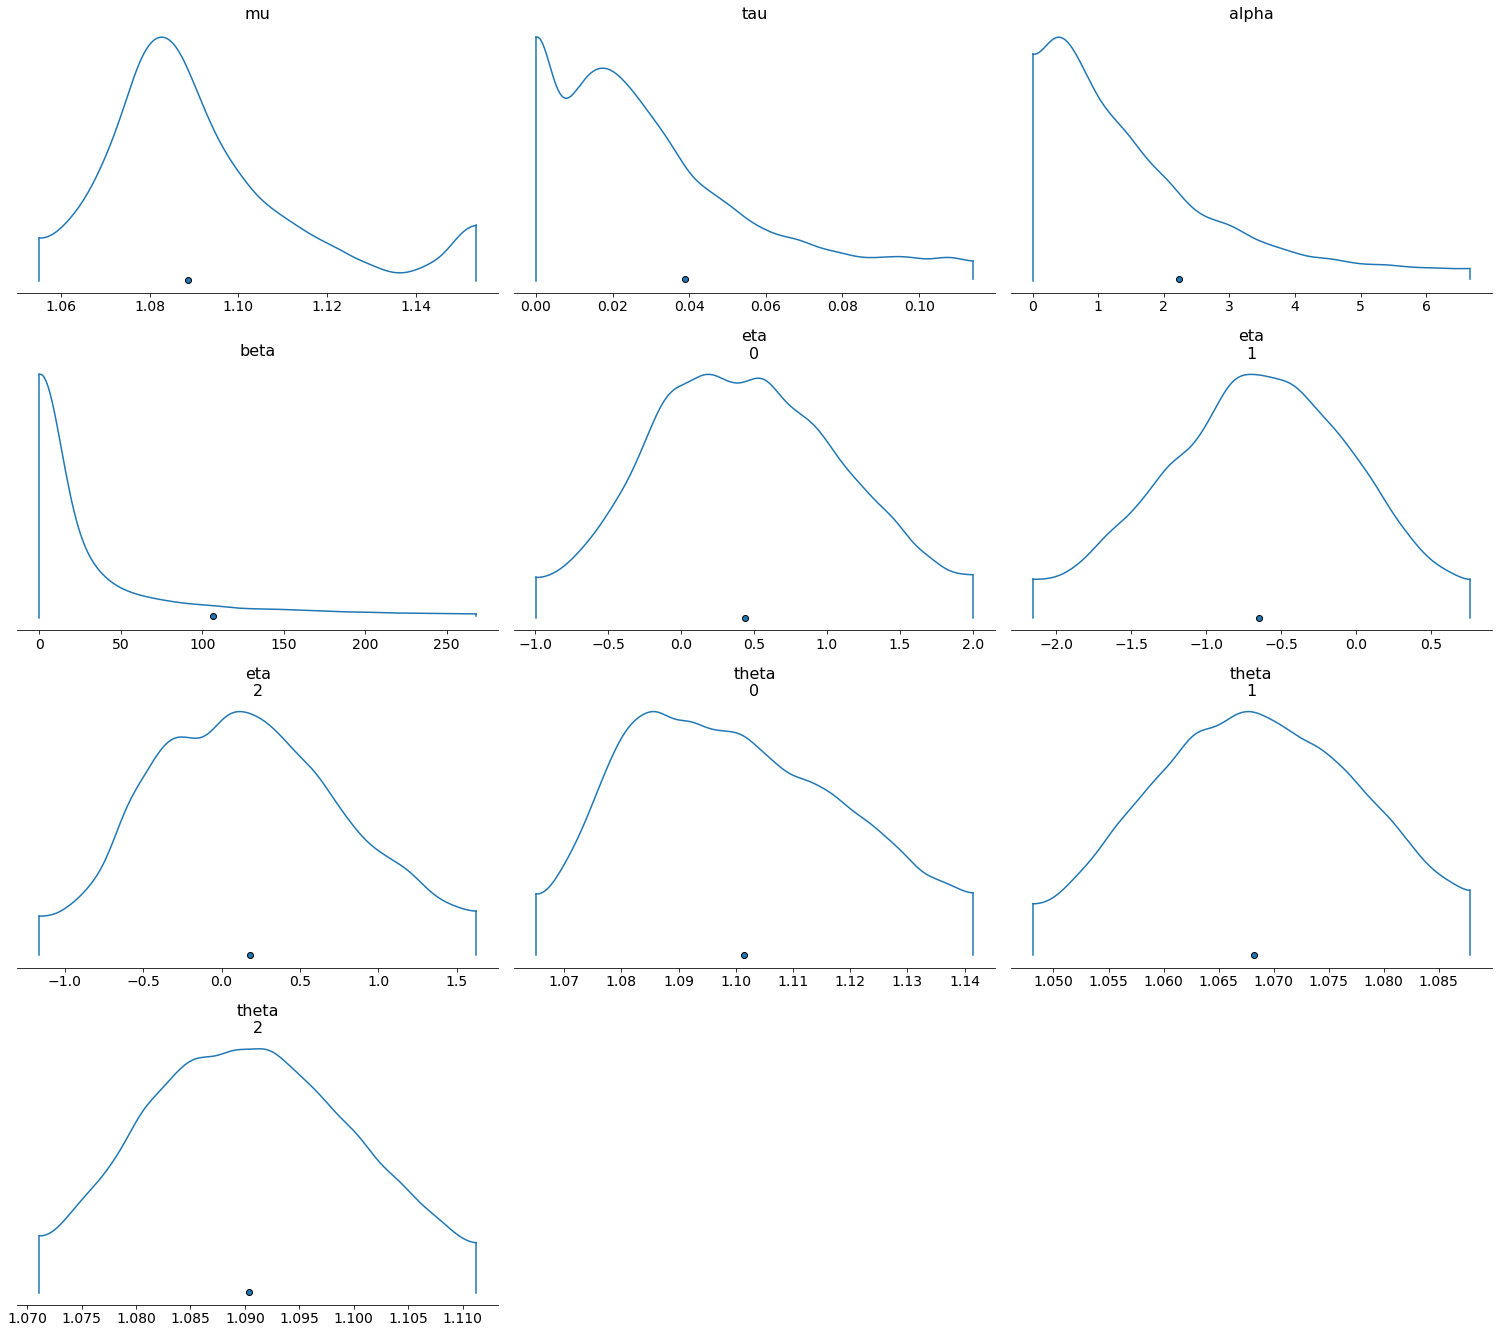

In [16]:
_ = arviz.plot_density(arviz.convert_to_inference_data(fit2))

### Posterior dist of p(theta|y) 
Let's draw the posterior distributions for both models, for all thetas and logp


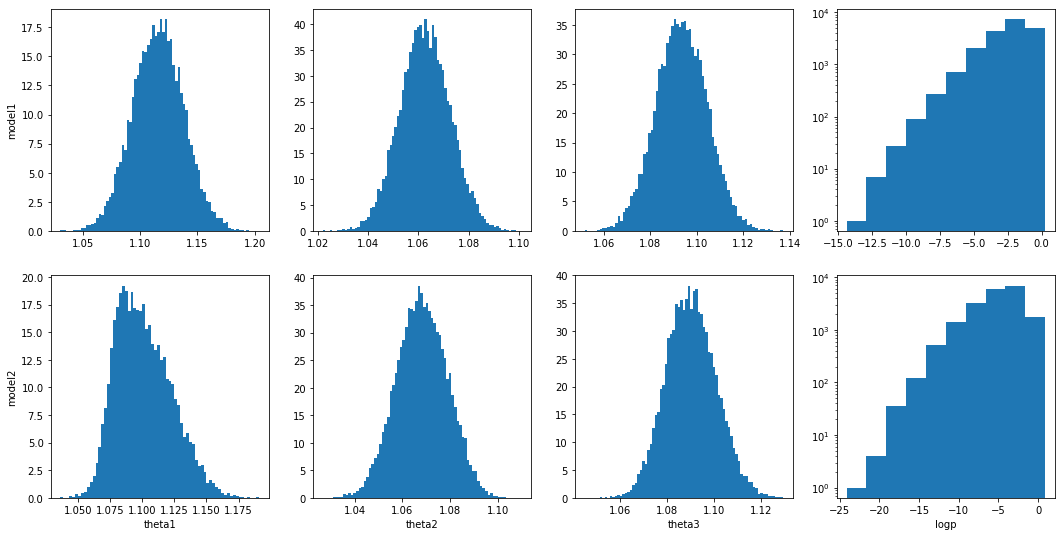

In [17]:
fig, ax = plt.subplots(2,4, figsize=(18, 9))
ax[-1][0].set_xlabel("theta1")
ax[-1][1].set_xlabel("theta2")
ax[-1][2].set_xlabel("theta3")
ax[-1][3].set_xlabel("logp")


ax[0][0].set_ylabel("model1")
ax[1][0].set_ylabel("model2")

# model 1
for i in range(3):
    ax[0][i].hist(theta[:,i], bins='auto', density=True)
    ax[1][i].hist(theta2[:,i], bins='auto', density=True)
    
_=ax[0][3].hist(logp)
_=ax[1][3].hist(logp2)
ax[1][3].set_yscale("log")
ax[0][3].set_yscale("log")

# Model checking

In this section, we check both models by posterior predictive distibution, using several test quantities: Minimium value, Maximum value, Median value

In [18]:
def draw_from_normal(mean, std):
    return np.random.normal(mean, std)

def draw(thetas, size=1):
    draws = []
    for index, theta in enumerate(thetas):
        draws.append(draw_from_normal(theta, std[index]))
    return draws

In [19]:
dataMin, dataMax, dataMedian = min(mean), max(mean), np.median(mean)
print(f"min:\t{dataMin:.3f}\nmax:\t{dataMax:.3f}\nmedian:\t{dataMedian:.3f}\n")

min:	1.063
max:	1.116
median:	1.093



In [20]:

def simulate(samples, nobs=1):
    simulation = []
    for iobs in range(nobs):
        i = np.random.randint(len(samples))
        thetas = samples[i, :]
        simulation.append(draw(thetas))
    return np.array(simulation)

In [21]:
simulate(theta)

array([[1.15268663, 1.06649543, 1.07637869]])

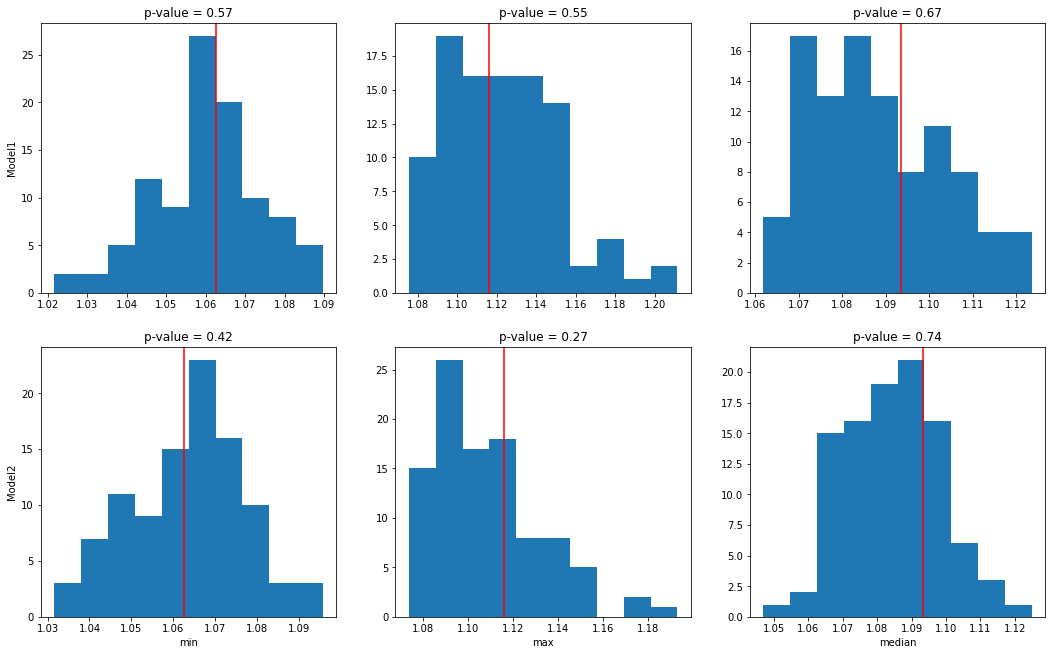

In [22]:
SAMPLES = [["Model1", theta],["Model2", theta2]]
NSIM = 100
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("min")
ax[-1][1].set_xlabel("max")
ax[-1][2].set_xlabel("median")
for i, (model, samples) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    min_max_median = []
    for j in range(NSIM):
        y = simulate(samples)
        min_max_median.append([y.min(), y.max(), np.median(y)])
    min_max_median = np.array(min_max_median)
    
    # plot data values of test variables as vertical red lines
    ax[i][0].axvline(dataMin, color="red")
    ax[i][1].axvline(dataMax, color="red")
    ax[i][2].axvline(dataMedian, color="red")
    # plot sampled values of test values as histograms
    for j in range(3):
        ax[i][j].hist(min_max_median[:, j], zorder=-1)
    
    # compute p-values and display them as subplot titles
    ax[i][0].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 0][min_max_median[:, 0] < dataMin]) /
        len(min_max_median)))
    ax[i][1].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 1][min_max_median[:, 1] > dataMax]) /
        len(min_max_median)))
    ax[i][2].set_title("p-value = {:.2f}".format(
        len(min_max_median[:, 2][min_max_median[:, 2] < dataMedian]) /
        len(min_max_median)))

It can be seen that both model perform pretty well on the chosen test quantities.

Let's try to visualize graphically the distribution of the 3 thetas, compared to the real average rate.

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(18, 6))
fig.subplots_adjust(top=1.5)
ax[-1][0].set_xlabel("theta1")
ax[-1][1].set_xlabel("theta2")
ax[-1][2].set_xlabel("theta3")

for i, (model, samples) in enumerate(SAMPLES):
    ax[i][0].set_ylabel(model)
    min_max_median = []
    y = simulate(samples, nobs=NSIM)
    
    for j in range(3):
        ax[i][j].boxplot(y[:,j])
        ax[i][j].plot(1, mean[j], marker='o', markersize=3, color="blue")

### Sensitvity Analysis
We will show the effect the hyperprior on tau and alpha. Then we show the effect of tau on theta in model 1 and 2, and see how sensitive the models are to the prior

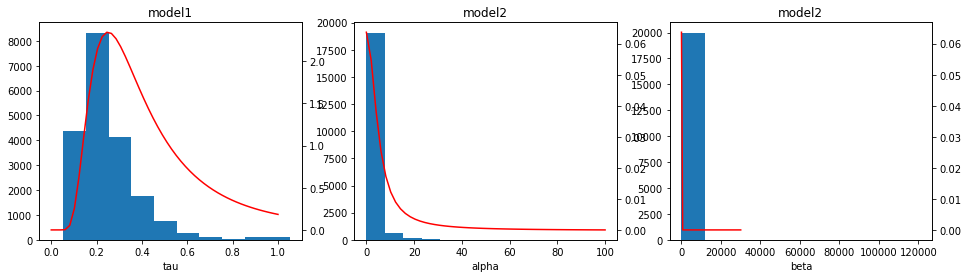

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_xlabel("tau")
ax[0].set_title("model1")
ax[0].hist(tau)
x = np.linspace(0, 1)
ax2= ax[0].twinx()
ax2.plot(x, scipy.stats.invgamma(3, scale=1).pdf(x), color='r')

ax[1].set_xlabel("alpha")
ax[1].set_title("model2")
ax[1].hist(alpha2)
x = np.linspace(0, 100)
ax3 = ax[1].twinx()
ax3.plot(x, scipy.stats.cauchy(0 ,5).pdf(x), color='r')


ax[2].set_xlabel("beta")
ax[2].set_title("model2")
ax[2].hist(beta2)
x = np.linspace(0, 30000)
ax3 = ax[2].twinx()
ax3.plot(x, scipy.stats.cauchy(0 ,5).pdf(x), color='r')

It can be seen that both tau and alpha depend on the prior, but something weird is going with beta. Now, in order to check the effect of tau on thetas, we will compute the mean of thetas values for each day, depends on tau value.

In [25]:
tau_val, tau_bin = np.histogram(tau, 10)
tau2_val, tau2_bin = np.histogram(tau2, 10)

thetas_by_tau_bins = np.zeros((10,3))
thetas_by_tau2_bins = np.zeros((10,3))
for i in range(len(theta)):
    for j, value in enumerate(theta[i]):
        tau_bin_number = np.where((tau_bin < tau[i]) == False)[0][0] - 1 if len(np.where((tau_bin < tau[i]) == False)[0]) is not 0 else -1
        thetas_by_tau_bins[tau_bin_number][j] += value
        
        
for i in range(len(theta2)):
    for j, value in enumerate(theta2[i]):
        tau2_bin_number = np.where((tau2_bin < tau2[i]) == False)[0][0] - 1 if len(np.where((tau2_bin < tau2[i]) == False)[0]) is not 0 else -1
        thetas_by_tau2_bins[tau2_bin_number][j] += value
        
thetas_by_tau_bins /= tau_val.repeat(3).reshape(10,3)
thetas_by_tau2_bins /= tau2_val.repeat(3).reshape(10,3)

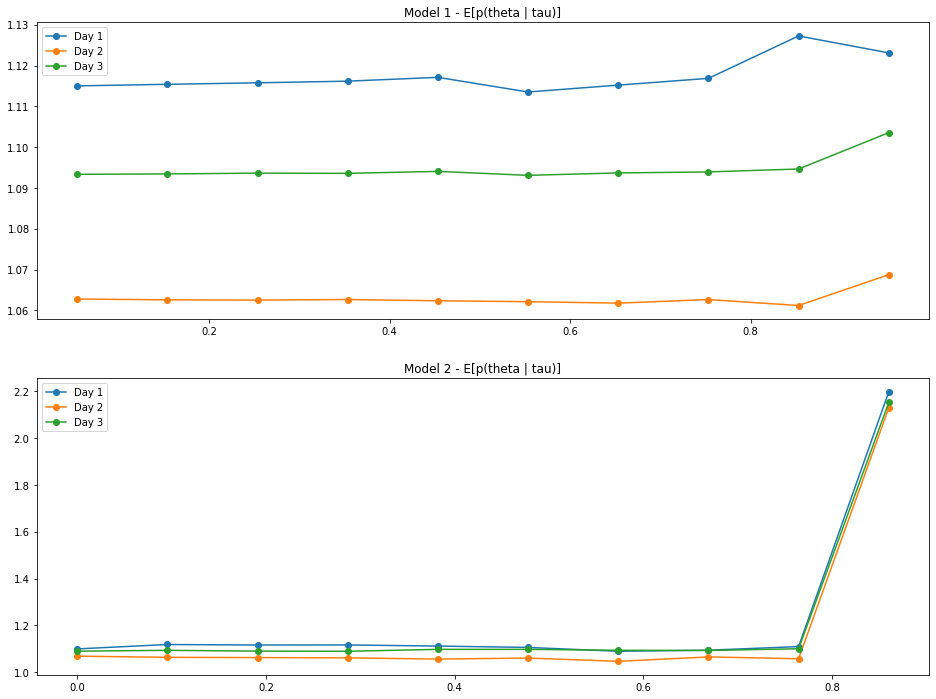

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

ax[0].set_title("Model 1 - E[p(theta | tau)]")
ax[1].set_title("Model 2 - E[p(theta | tau)]")
for index, val in enumerate(thetas_by_tau_bins.T):
    ax[0].plot(tau_bin[:-1], val, marker='o', label=f"Day {index + 1}")
 
for index, val in enumerate(thetas_by_tau2_bins.T):
    ax[1].plot(tau2_bin[:-1], val, marker='o', label=f"Day {index + 1}")
_ = ax[0].legend()
_ = ax[1].legend()

It can be seen that in the first model, where tau ~ inverse_gamma(3,1), theta are not so sensitive to the value of tau, as only in the first day the mean of theta is changing significantlly.

But, in the second model, where tau ~ gamma(alpha, beta), where alpha&beta ~ cauchy(0, 5), it can be seen that there's a very significant change in the edge of tau value, for all 3 thetas. We can say, this model is more sensitive to tau value thus more sensitive to prior definition.

### WAIC Evaluation ###

In [28]:
theta.shape, theta2.shape

((20000, 3), (20000, 3))

In [29]:
theta[100,0]

1.1667613761496378

In [30]:
from scipy.stats import norm

def lppd(theta_samples, points, std):
    lppd = 0
    for i in range(theta_samples.shape[1]):  #Iterating on days
        day_ppd = 0
        for j in range(theta_samples.shape[0]): #Iterating on samples from posterior
            day_ppd += norm.pdf(points[i],theta_samples[j,i],std[i]) #Compute likelihood of parameters
        day_ppd /= theta_samples.shape[0]
        lppd += np.log(day_ppd)
    return lppd

In [31]:
lppd_1 = lppd(theta, mean,std)
lppd_2 = lppd(theta2, mean,std)

In [32]:
def pwaic1(theta_samples, points, std):
    waic = 0
    for i in range(theta_samples.shape[1]): #Iterating on days
        p=0
        logp=0
        for j in range(theta_samples.shape[0]): #Iterating on samples from posterior
            p+=norm.pdf(points[i],theta_samples[j,i],std[i]) 
            logp+=norm.logpdf(points[i],theta_samples[j,i],std[i]) 
        p/=theta_samples.shape[0]
        logp/=theta_samples.shape[0]
        waic += np.log(p) - logp
    return 2*waic

In [33]:
def pwaic2(theta_samples, points, std):
    waic = 0
    for i in range(theta_samples.shape[1]): #Iterating on days
        p=0
        logp=0
        for j in range(theta_samples.shape[0]): #Iterating on samples from posterior
            p+=norm.pdf(points[i],theta_samples[j,i],std[i]) 
            logp+=norm.logpdf(points[i],theta_samples[j,i],std[i]) 
        p/=theta_samples.shape[0]
        logp/=theta_samples.shape[0]
        waic += np.log(p) - logp
    return 2*waic

In [34]:
model1_pwaic1 = pwaic1(theta,mean,std)
model2_pwaic1 = pwaic1(theta2,mean,std)

In [35]:
model1_pwaic1, model2_pwaic1

(0.9175089988748271, 1.221837784273471)

In [36]:
elppd_waic1_model1 = lppd_1 - model1_pwaic1
elppd_waic1_model2 = lppd_2 - model2_pwaic1

In [37]:
elppd_waic1_model1, elppd_waic1_model2

(8.19949308989257, 7.629390489744396)

### It can be seen that the second model had lower waic, therefore it gives the best average predictive performance.
### We could of course compute waic2, which is generally more recommended because in practice it gives results closer to LOO-CV.